# Persistent Homology of Collocations and Multiword Expressions Across Contexts for Hebrew

This notebook is for comparing how well two models preserves the persistent homology of some keyphrase like a collocation, multiword expression, or idiom. We take such a keyphrase and place it in several different contexts `text[i]`, then compute the persistent homology of the context vectors in each context. Once this is complete, we compute the pairwise distances between the persistent diagrams using the Wasserstein distance metric. This gives two distance matrices, one for each mode (here we use `xlm-roberta-large` and `TurkuNLP/wikibert-base-he-cased`). Once we have computed this distance matrix, we do a simple elementwise comparison to see what percentage of the elements in the difference of the two distance matrices are negative. Note that this is a per attention head comparison, so we can compare different attention heads in each model. Changing the second function `compute_output_b()` to use the first model `xlm-roberta-large` allows for comparing different attention heads *within the same model*. 

In [102]:
pip install transformers torch numpy gudhi -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [103]:
text = ["בחופשה האחרונה שלנו, נסענו להכיר את היופיים של מדבר הנגב. בין אם מדובר בצוקים המרשימים, בחי הבר המיוחד, או בשקט המוחלט, יש משהו מאוד מיוחד במדבר. אחת החוויות המרגשות ביותר שלנו הייתה לצפות בזרחת השמש מעל המדבר. האור המתפשט מאחורי ההרים, השמים המשתנים מאוד מהיר מאופל לתכלת, והשלווה המוחלטת שאפשר רק במדבר, הכל הפך את החוויה לבלתי נשכחת", 
          
          "במהלך שנת הלימודים הראשונה שלי באוניברסיטה, הצטרפתי לקבוצת טיול שהגיעה להר האייפל. למרות הקור החודר, הייתי מחויב לעלות לפסגה בכל בוקר, כדי לצפות בזרחת השמש מעל פריס", 
          
          "הייתי מתעורר בבוקר מוקדם, לפני כולם, כדי לצפות בזרחת השמש. היו ימים שהשמים היו מלאים בגוונים של ורוד וכתום, והאוויר הקר היה ממלא את הריאות. הייתי נושם את השקט, מאזין לשירת הציפורים, ומרגיש את היום החדש שמתחיל.", 
          
          "הייתה לי הרגל לצפות בזרחת השמש כאשר הייתי טסה למקומות רחוקים. הייתי מתמקדת באור הזהב של השמש שהתפשט על פני האופק. זה היה רגע של שקט ושלווה, שבו הייתי מרגישה את האפשרויות של היום שלפני.", 
          
          "אחד הדברים שאני ממש אוהב לעשות בחופשות הוא לצפות בזרחת השמש על גג המלון. אין דבר יותר מרגיע מאשר לשבת עם כוס קפה ביד, להתבונן בנוף, ולראות איך העולם מתעורר לחיים.", 
          
          "במהלך ההליכה, עצרנו לרגע כדי לצפות בזרחת השמש. האור הראשוני של היום הזהיר את השמיים בצבעים של זהב, ואנחנו ישבנו שם בשקט, מתפללים ליום טוב.", 
          
          "אני מאמין שאין דבר מרגש יותר מ לצפות בזרחת השמש. כאשר האור הראשונים מתחילים להתפשט באופק, אתה מרגיש כאילו אתה חלק ממשהו גדול מאוד. זה מזכיר לי כמה העולם הזה גדול ויפה.", 
          
          "אחת הפעמים המיוחדות ביותר שבהן הזמנתי לצפות בזרחת השמש הייתה בחופשה שלי בהודו. הייתי מתעורר מוקדם, לפני כל העולם, ומשתקף למראה המרהיבה של השמש המתעלה מעל האוקיינוס. זה היה חוויה שאני לעולם לא אשכח.", 
          
          "אני אוהב לצפות בזרחת השמש מהחלון שלי. זה נותן לי את האנרגיה להתחיל את היום. אני אפילו מקדיש כמה דקות בכל בוקר לקחת כוס קפה, לשבת מול החלון, ולהשתקף במראה המדהים הזה.", 
          
          "בראשית, אני אוהב לצפות בזרחת השמש מהמרפסת שלי. זה מזכיר לי את היופי של העולם, את התקווה של יום חדש, ואת החיים הממשיכים להתפתח בכל יום. כל זריחה מציגה תמונה שונה, נוף חדש שממלא אותי בתחושת התרגשות והתפעלות.", 
          
          "היום האחרון שלי ביפן היה יום מיוחד. יצאתי להליך מוקדם בבוקר, כדי לצפות בזרחת השמש מעל הר הפוג'. האור הראשוני של היום מאיר את השיחים המקופים בשלג, מצייר תמונה יפהפיה שאני לעולם לא אשכח.", 
          
          "אחד החוויות המרגשות ביותר שלי היתה לצפות בזרחת השמש מעל הפירמידות במצרים. האור החום החודר את השחקים, מאיר את האבנים העתיקות, ומעניק להם מראה של זהב. זה היה רגע של התבוננות והתפעלות על ההיסטוריה שלנו.", 
          
          "כאשר אני מטייל בים, אני מתכנן לצפות בזרחת השמש מהחוף. אין דבר מרהיב יותר מלראות את האור הראשון של היום מתפשט על גלי הים, משנה את צבעם לגוונים של זהב ואורנג'. זה הופך את החוויה של ההליכה למשהו יוצא דופן.", 
          
          "האלפים היה חלום שלי. כשהגעתי לשם, הייתי עייף אבל מרוצה. לצפות בזרחת השמש מהפסגה, כשהאור העדין של השחר התחיל להתפשט על השפעי השלג הלבנים, היה חוויה בלתי נשכחת. העולם התמלא בנופים שלא ראיתי מעולם. זה היה מרגע של שלווה ושקט, שהיה שווה את כל המאמץ.", 
          
          "אחרי שהוא התעורר מהשנה, איזיק הכין לעצמו כוס קפה והולך להסתובב בגן הפרטי שלו. זו הייתה הדרך האהובה עליו להתחיל את היום - לצפות בזרחת השמש ולשמוע את הציפורים מצפצפות.", 
          
          "את חייבת לצפות בזרחת השמש מהחוף שלנו, אמר יגאל למרים, כאשר הם הגיעו לבית הנופש של המשפחה. זו תחוויה בלתי נשכחת, משהו שתזכורי לעוד שנים.",
          
          "בזמן שהכל בעיר עדיין ישן, רבקה מתעוררת בשעה המוקדמת ביותר שאפשר, מתארגנת, ויוצאת לרוץ. היא אוהבת את השקט של אותן שעות, והמראה של העיר שמתעוררת לחיים. אבל מעל כל, זה הזמן היחיד שהיא יכולה לצפות בזרחת השמש בלי להיות מופרעת.",

          "לשפת האגם הגיעה מיה, המצלמה שלה כבר מוכנה לפעולה. היא התיישבה בשקט, מצפה לרגע הנכון. היא יודעת שממש בקרוב, היא תהיה מסוגלת לצפות בזרחת השמש, והיא רוצה לתפוס את הרגע המושלם בתמונה.", 

          "אחד הדברים המרגשים ביותר בנסיעה לאילת הוא ההזדמנות לצפות בזרחת השמש מעל המדבר. השמים משנים את צורתם מכל הכיוונים, מתוך כך מתמלאים בצבעים רבים, מאוד רומנטי. זהו זמן מיוחד להיות בהם, ולהרגיש את השקט שממלא את האוויר.", 

          "הלכתי לשבת על החוף, מחכה לצפות בזרחת השמש. הים היה שקט ומנוחה, האור הפליד התחיל להתפשט באופק. כשהשמש קמה, היא הפכה את השמים לפריים של צבעים מרהיבים. זה היה רגע של שלווה ושקט, שהגיע לפיקו בזריחה המרהיבה."


]


In [104]:
for i in range(len(text)):
    print(i, text[i])

0 בחופשה האחרונה שלנו, נסענו להכיר את היופיים של מדבר הנגב. בין אם מדובר בצוקים המרשימים, בחי הבר המיוחד, או בשקט המוחלט, יש משהו מאוד מיוחד במדבר. אחת החוויות המרגשות ביותר שלנו הייתה לצפות בזרחת השמש מעל המדבר. האור המתפשט מאחורי ההרים, השמים המשתנים מאוד מהיר מאופל לתכלת, והשלווה המוחלטת שאפשר רק במדבר, הכל הפך את החוויה לבלתי נשכחת
1 במהלך שנת הלימודים הראשונה שלי באוניברסיטה, הצטרפתי לקבוצת טיול שהגיעה להר האייפל. למרות הקור החודר, הייתי מחויב לעלות לפסגה בכל בוקר, כדי לצפות בזרחת השמש מעל פריס
2 הייתי מתעורר בבוקר מוקדם, לפני כולם, כדי לצפות בזרחת השמש. היו ימים שהשמים היו מלאים בגוונים של ורוד וכתום, והאוויר הקר היה ממלא את הריאות. הייתי נושם את השקט, מאזין לשירת הציפורים, ומרגיש את היום החדש שמתחיל.
3 הייתה לי הרגל לצפות בזרחת השמש כאשר הייתי טסה למקומות רחוקים. הייתי מתמקדת באור הזהב של השמש שהתפשט על פני האופק. זה היה רגע של שקט ושלווה, שבו הייתי מרגישה את האפשרויות של היום שלפני.
4 אחד הדברים שאני ממש אוהב לעשות בחופשות הוא לצפות בזרחת השמש על גג המלון. אין דבר יותר מרגיע מא

In [105]:
import torch
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel 
import transformers

def compute_output_model(tokenizer, model, sentence, layer, head):
    # Load pre-trained model

    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O

In [106]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')
model = AutoModel.from_pretrained("xlm-roberta-large", output_attentions=True) 


# Set the layer and head to use for computation
layer = 7
head = 3

context = []
for i in range(len(text)):
    context.append(compute_output_model(tokenizer, model, text[i], layer, head))

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [107]:
print(context[17].shape)
print(context[17])

torch.Size([1, 63, 64])
tensor([[[ 0.0542,  0.0071,  0.0059,  ...,  0.0344, -0.0120, -0.0591],
         [-0.0936,  0.0692,  0.1255,  ..., -0.1454, -0.0798, -0.1465],
         [ 0.0190,  0.0147,  0.0678,  ..., -0.0105, -0.0418, -0.0803],
         ...,
         [-0.0260,  0.0474,  0.1041,  ..., -0.0767, -0.1092, -0.0647],
         [ 0.0548,  0.0398,  0.0012,  ...,  0.0185, -0.0164, -0.0439],
         [ 0.0397,  0.0141,  0.0141,  ...,  0.0170, -0.0228, -0.0616]]],
       grad_fn=<CloneBackward0>)


In [108]:
from scipy.spatial import distance_matrix
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

def compute_phrase_distances_and_homology(tokenizer, context_vectors, sentence, phrase):
    # Initialize the tokenizer

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Print the tokens of the sub-collection and their context vectors
    # print(f'Tokens of the sub-collection: {tokenizer.convert_ids_to_tokens(phrase_tokens)}')
    # print(f'Context vectors of the sub-collection: {phrase_context_vectors_np}')

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Print the distance matrix
    # print(f'Distance matrix: {distances.shape}')
    # print(f'Distance matrix: {distances}')

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    # Plot the barcode diagram
    # gd.plot_persistence_barcode(persistence=persistent_homology)
    # plt.show()

    return persistent_homology

In [109]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')

persistent_homology = []
for i in range(len(text)):
    persistent_homology.append(compute_phrase_distances_and_homology(tokenizer, context[i], text[i], "לצפות בזרחת השמש"))

In [110]:
persistent_homology[17]

[(0, (0.0, inf)),
 (0, (0.0, 0.32874179189208463)),
 (0, (0.0, 0.22278926164197888)),
 (0, (0.0, 0.1982252697136126)),
 (0, (0.0, 0.1729591248632601)),
 (0, (0.0, 0.08654359716326993))]

In [111]:
from gudhi.hera import wasserstein_distance
import numpy as np

persistent_homology_np = [np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology[i] if pt[1][1] != float('inf')]) for i in range(len(persistent_homology))]

print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np[17], persistent_homology_np[1], order=1., internal_p=2.):.2f}")


Wasserstein distance: = 0.64


In [112]:
from gudhi.hera import wasserstein_distance
import numpy as np

def transform_persistence_diagram(diagram):
    # Remove the dimension from each feature and return the transformed diagram
    return [(birth, death) for dimension, (birth, death) in diagram]

def compute_wasserstein_distances(persistence_diagrams, p=2):
    n = len(persistence_diagrams)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            diagram1 = transform_persistence_diagram(persistence_diagrams[i])
            diagram2 = transform_persistence_diagram(persistence_diagrams[j])
            distance = wasserstein_distance(diagram1, diagram2, order=1., internal_p=2.)
            distances[i, j] = distance
            distances[j, i] = distance
    return distances

In [113]:
persistence_diagrams = []
for i in range(len(text)):
    persistence_diagrams.append(persistent_homology[i])

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

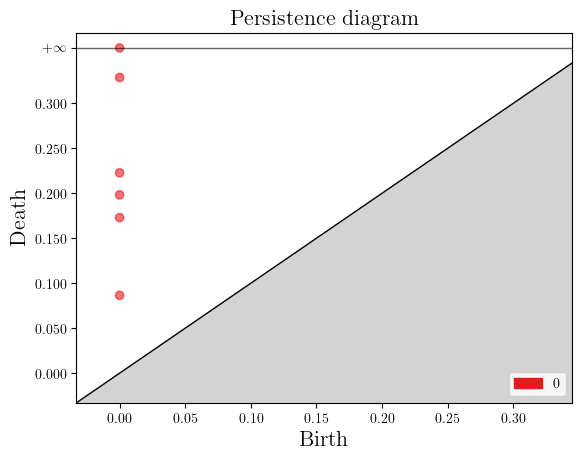

In [114]:
gd.plot_persistence_diagram(persistence = persistence_diagrams[17])

In [115]:
w_distances = compute_wasserstein_distances(persistence_diagrams)
print(w_distances.shape)
print(w_distances)

(20, 20)
[[0.         0.14358496 0.70826325 0.4711087  0.46510486 0.66519472
  0.72106172 0.64639516 0.25645569 0.74026037 0.57935826 0.66323981
  0.65809475 0.50263554 0.33131627 0.75071186 0.62353368 0.6456653
  0.38157927 0.69854785]
 [0.14358496 0.         0.6067536  0.38272286 0.46688104 0.52160976
  0.63267588 0.53151107 0.30987864 0.78782533 0.50614469 0.68760714
  0.65631857 0.47948699 0.36945366 0.66232602 0.58357096 0.64388911
  0.36721014 0.75197079]
 [0.70826325 0.6067536  0.         0.51532513 0.87037348 0.35806367
  0.24278376 0.17987196 0.63386834 0.35499558 0.128905   1.15788785
  0.17214855 0.39345292 0.62027882 0.42893342 0.15904181 0.19465545
  0.36231651 0.30955749]
 [0.4711087  0.38272286 0.51532513 0.         0.46565468 0.25949316
  0.34015762 0.37705579 0.39888494 0.73971055 0.48912666 0.89639451
  0.65414876 0.35109556 0.2456747  0.30970259 0.4746897  0.64511548
  0.36843651 0.6967763 ]
 [0.46510486 0.46688104 0.87037348 0.46565468 0.         0.66451876
  0.7797

---

In [116]:
tokenizer_b = transformers.BertTokenizer.from_pretrained("TurkuNLP/wikibert-base-he-cased")
model_b = transformers.BertModel.from_pretrained("TurkuNLP/wikibert-base-he-cased", output_attentions=True)

# Set the layer and head to use for computation
layer = 7
head = 3

context_b = []
for i in range(len(text)):
    context_b.append(compute_output_model(tokenizer_b, model_b, text[i], layer, head))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of the model checkpoint at TurkuNLP/wikibert-base-he-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializi

In [117]:
print(context_b[17].shape)
print(context_b[17])

torch.Size([1, 53, 64])
tensor([[[ 0.0816,  0.0383,  0.0506,  ..., -0.1030, -0.0738, -0.0103],
         [-1.6834,  0.5611, -0.6717,  ...,  0.0183, -0.7205, -0.4127],
         [-0.1397,  0.2528, -0.1753,  ..., -0.0289, -0.1818, -0.3452],
         ...,
         [-0.3615,  0.1164, -0.7705,  ..., -0.9037, -0.1315, -0.0657],
         [-0.0168,  0.0257,  0.0390,  ..., -0.0340, -0.0192,  0.0217],
         [ 0.0350,  0.0603,  0.0587,  ..., -0.0388, -0.0684,  0.0258]]],
       grad_fn=<CloneBackward0>)


In [118]:
tokenizer_b = transformers.BertTokenizer.from_pretrained("TurkuNLP/wikibert-base-he-cased")

persistent_homology_b = []
for i in range(len(text)):
    persistent_homology_b.append(compute_phrase_distances_and_homology(tokenizer_b, context_b[i], text[i], "לצפות בזרחת השמש"))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [119]:
persistent_homology_b[17]

[(0, (0.0, inf)),
 (0, (0.0, 3.266277594465306)),
 (0, (0.0, 2.868081424448777)),
 (0, (0.0, 2.649657861064285)),
 (0, (0.0, 0.3073455881185572))]

In [120]:
persistence_diagrams_b = []
for i in range(len(text)):
    persistence_diagrams_b.append(persistent_homology_b[i])

In [121]:
w_distances_b = compute_wasserstein_distances(persistence_diagrams_b)
print(w_distances_b.shape)
print(w_distances_b)

(20, 20)
[[0.         2.00565851 2.02341953 1.89525015 1.79904539 2.92925413
  1.89446117 2.15259425 2.28771593 1.90800819 1.23059814 1.139906
  0.77614528 2.29766378 1.40165381 2.52970219 0.80765267 1.69892072
  1.63081072 1.44306142]
 [2.00565851 0.         0.51545683 1.63683597 2.95155151 1.36038349
  1.08698407 0.45105745 1.05606521 1.29591205 1.49407203 1.34422249
  1.50480751 4.30332229 1.46108677 3.5099754  1.91115299 2.48764878
  1.52113338 1.07132839]
 [2.02341953 0.51545683 0.         1.80561389 2.96931254 1.05822042
  1.39349731 0.88865973 0.58552582 0.81466701 1.02588328 1.36198351
  1.55041486 4.32108332 1.03477889 3.52773643 1.92891402 1.97855742
  1.56037527 1.08908942]
 [1.89525015 1.63683597 1.80561389 0.         1.52819915 2.51441809
  1.31215502 1.5702881  1.81074453 2.51974226 2.81844089 1.81496752
  1.44205    3.50166601 2.73836738 4.42495234 2.56815022 3.5241831
  0.9596745  2.13118684]
 [1.79904539 2.95155151 2.96931254 1.52819915 0.         4.00470687
  2.840354

In [122]:
print(w_distances - w_distances_b)

[[ 0.         -1.86207354 -1.31515628 -1.42414145 -1.33394053 -2.26405941
  -1.17339945 -1.50619909 -2.03126024 -1.16774782 -0.65123989 -0.47666619
  -0.11805053 -1.79502824 -1.07033754 -1.77899033 -0.18411899 -1.05325542
  -1.24923145 -0.74451357]
 [-1.86207354  0.          0.09129677 -1.25411312 -2.48467047 -0.83877373
  -0.45430818  0.08045363 -0.74618658 -0.50808671 -0.98792734 -0.65661535
  -0.84848894 -3.8238353  -1.09163311 -2.84764938 -1.32758203 -1.84375967
  -1.15392324 -0.3193576 ]
 [-1.31515628  0.09129677  0.         -1.29028876 -2.09893906 -0.70015675
  -1.15071355 -0.70878776  0.04834252 -0.45967143 -0.89697828 -0.20409566
  -1.37826631 -3.9276304  -0.41450007 -3.09880301 -1.76987221 -1.78390197
  -1.19805876 -0.77953193]
 [-1.42414145 -1.25411312 -1.29028876  0.         -1.06254448 -2.25492492
  -0.97199741 -1.19323231 -1.41185959 -1.78003171 -2.32931423 -0.91857301
  -0.78790124 -3.15057044 -2.49269269 -4.11524975 -2.09346052 -2.87906762
  -0.59123799 -1.43441053]
 [-1

In [123]:
import numpy as np

def count_negative_entries_below_diagonal(matrix):
    count = 0
    total = 0
    n = len(matrix)
    for i in range(n):
        for j in range(i):
            if matrix[i][j] < 0:
                count += 1
            total += 1
    return count, total

# example matrix
matrix = w_distances - w_distances_b

negative_count, total_count = count_negative_entries_below_diagonal(matrix)
percentage = (negative_count / total_count) * 100
print("Percentage of negative entries below the diagonal: ", percentage)


Percentage of negative entries below the diagonal:  97.36842105263158


## Interpreting the results

So, as we can see, the percentage of negaive entries below the diagonal is approximately $97.37\%$, meaning $97.37\%$ of the time the Wasserstein distance between persistence diagrams for the phrase "לצפות בזרחת השמש" in various different contexts (given by the text corpera `text[i]` in `text` at the beginning of the notebook) is larger for `TurkuNLP/wikibert-base-he-cased` than for `xlm-roberta-large`. This means that the `TurkuNLP/wikibert-base-he-cased` model does not preserve the persistent homology for the context vectors associated to the phrase "לצפות בזרחת השמש" as well. In fact $100\%$ of the time `xlm-roberta-large` has smaller Wasserstine distance between persistence diagrams than `TurkuNLP/wikibert-base-he-cased` for almost every pair of persistence diagrams. Note, this is comparing `head 3` of `layer 7` in the models. When we compare different heads this number will change and some heads drastically outperform others at preserving persistent homology of keyphrases. 

It is interesting to note that we might linguistically analyze a model's individual attention heads using this method to determine what kinds of keyphrases it preserves. We might also use this to modify attention heads to better understand certain keyphrases. This is closely linked to topic modeling as is mentioned in [Topics in Contextualised Attention Embeddings](https://arxiv.org/pdf/2301.04339.pdf). This, along with the Fréchet mean of persistence diagrams could also be used for anomaly detection, where an anomaly is considered a "significant" deviation from the Fréchet mean persistence diagram. For character level transformers this might also be used as a topological prior to obtain something like hierarchical morphological segmentations of words, where the hierarchy is given by the simplex tree, and the simplex tree is encouraged to mimic heirarchical morphological segmentation of words similar to what is described in [Morphological Segmentation Inside-Out](https://arxiv.org/abs/1911.04916v2). 